### Barbara Karakyriakou
###  MCB112
### homework 7:
### the cycle of twelve

In this assignment, we will be fitting time-course gene expression data using "harmonic regression", a slightly modified form of linear regression.

#### the available data

In [115]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.optimize as optimize
from scipy import stats
from scipy.interpolate import spline

ImportError: cannot import name 'spline' from 'scipy.interpolate' (/Applications/anaconda3/lib/python3.7/site-packages/scipy/interpolate/__init__.py)

In [92]:
# create a dataframe with the data

df = pd.read_table('w07-data.txt', sep='\s+', escapechar='-')

df.columns=['4hr', '4hr', '8hr', '8hr', 
                           '16hr', '16hr', '24hr', '24hr']
df.index.name ='gene'

df = df.rename({'gene':'sigma'}, axis='index') # create a row with the sigma values

df = df.drop(df.index[[1]])

df = df.astype('float') # convert data to floats

df

,4hr,4hr,8hr,8hr,16hr,16hr,24hr,24hr
gene,,,,,,,,
sigma,20.00,2.00,20.00,5.00,5.00,20.00,2.00,20.00
anise,109.77,72.66,20.56,56.19,25.28,0.00,60.12,50.41
kiwi,12.73,18.81,54.50,45.41,68.87,52.19,20.02,33.38
carrot,62.25,60.75,52.48,36.12,20.47,27.77,59.04,40.98
grape,15.64,22.59,50.08,35.41,68.81,70.85,35.55,68.25
tangerine,47.88,31.65,9.36,20.77,54.15,22.44,56.57,71.97
melon,52.94,56.61,65.61,24.75,28.00,0.00,64.52,49.56
clementine,2.56,32.65,51.08,55.65,57.87,58.38,11.88,17.46
spinach,84.98,65.22,52.50,63.15,34.64,32.18,48.84,47.48


In [66]:
# create an array with the gene names

gene_name = df.index[1:].values
gene_name

array(['anise', 'kiwi', 'carrot', 'grape', 'tangerine', 'melon',
       'clementine', 'spinach', 'beet', 'huckleberry', 'lentil',
       'cauliflower'], dtype=object)

In [67]:
# create an array with the sigma values (standard deviations)

sigma = df.iloc[0,:].values
sigma

array([20.,  2., 20.,  5.,  5., 20.,  2., 20.])

In [68]:
# create an array with the TPM values of each gene

genes = df.iloc[1:,:].values
genes

array([[109.77,  72.66,  20.56,  56.19,  25.28,   0.  ,  60.12,  50.41],
       [ 12.73,  18.81,  54.5 ,  45.41,  68.87,  52.19,  20.02,  33.38],
       [ 62.25,  60.75,  52.48,  36.12,  20.47,  27.77,  59.04,  40.98],
       [ 15.64,  22.59,  50.08,  35.41,  68.81,  70.85,  35.55,  68.25],
       [ 47.88,  31.65,   9.36,  20.77,  54.15,  22.44,  56.57,  71.97],
       [ 52.94,  56.61,  65.61,  24.75,  28.  ,   0.  ,  64.52,  49.56],
       [  2.56,  32.65,  51.08,  55.65,  57.87,  58.38,  11.88,  17.46],
       [ 84.98,  65.22,  52.5 ,  63.15,  34.64,  32.18,  48.84,  47.48],
       [ 11.93,  25.22,  20.58,  26.43,  60.33,  69.68,  44.47,  51.03],
       [ 73.92,  60.69,  62.34,  69.59,  39.76,  17.31,  33.45,  48.6 ],
       [ 49.72,  44.88,  16.71,  24.28,  39.94,  65.69,  62.89,  40.72],
       [ 49.95,  39.98,  68.16,  66.92,  40.3 ,  17.36,  18.78,  41.72]])

#### 1. solve by maximum likelihood
#### solve this one using multidimensional optimization using SciPy's optimize.minimize() function.

In [69]:
# log likelihood function to be passed to SciPy's optimize.minimize() function
# the mu is calculated by linear regression with three parameters (p0,p1,p2)
# the math function is yt=p0+p1sin(2πωt)+p2cos(2πωt) 
# it takes guessed values for the 3 parameters (p), the sigmas (X) $ the observations (y)

def nll(p, X, y):
    p0  = p[0]
    p1  = p[1]
    p2  = p[2]
    ll = 0.
    t = [4., 4., 8., 8., 16., 16., 24., 24.] # an array with t values from each experiment
    for i in range(len(X)):
        # predict thw parameters for all 8 experiments 
        ypred = p0 + p1*np.sin(2*math.pi*(t[i])/24) + p2*np.cos(2*math.pi*(t[i])/24)
        residual = ypred - y[i] # residual between predictions and observations
        ll += stats.norm.logpdf(residual, 0, X[i]) #calculate ll for each sigma
    return -ll

In [70]:
# a random guess of the three parameters

p = [40, 20, 10]

In [71]:
# loop over the each gene and calculate the parameters using optimize.minimize()

results = [] # store the results

for i in range(len(genes)): # loop over each gene
    # pass nll func with guessed parameters, sigmas, and observations to the minimizer. 
    minimize = optimize.minimize(nll, p, (sigma, genes[i]), 
                                 bounds = [(None,None), (None,None), (None,None)])
    result = minimize.x
    results.append(result)
print(results)

[array([46.87769817, 21.02187232, 13.83174732]), array([ 44.16259886, -14.61055083, -24.38758775]), array([39.64848292, 12.06774028, 19.74222793]), array([ 46.54210846, -20.73401545, -11.03363517]), array([ 42.66803609, -20.01041238,  13.77692099]), array([40.09997299,  3.60029911, 24.88181172]), array([ 42.99852121,   3.44290317, -30.11151403]), array([49.11359587, 18.11992599,  0.0895696 ]), array([ 43.51770692, -21.31642194,   0.77856717]), array([ 48.02066499,  21.44341704, -13.70061003]), array([42.85340341, -9.39508934, 19.968266  ]), array([ 40.85600596,  13.10273405, -22.4489618 ])]


In [72]:
# check if we have 12 results

len(results)

12

In [73]:
# test for accuracy

minimize = optimize.minimize(nll, p, (sigma, genes[6]))
minimize, results[6]

(      fun: 26.34463084711362
  hess_inv: array([[ 4.31350059, -2.06527299, -3.52570133],
        [-2.06527299,  5.42330638,  0.15091203],
        [-3.52570133,  0.15091203,  6.31524037]])
       jac: array([-6.19888306e-06,  0.00000000e+00,  1.19209290e-06])
   message: 'Optimization terminated successfully.'
      nfev: 80
       nit: 14
      njev: 16
    status: 0
   success: True
         x: array([ 42.99848712,   3.44290213, -30.11145816]),
 array([ 42.99852121,   3.44290317, -30.11151403]))

In [74]:
# test if the results are the same for differend random guessed parameters

test_p = [100, 50, 2] 

test_results = [] # store the test results

for i in range(len(genes)): # loop over each gene
    # pass nll func with guessed parameters, sigmas, and observations to the minimizer. 
    minimize = optimize.minimize(nll, p, (sigma, genes[i]), 
                                 bounds = [(None,None), (None,None), (None,None)])
    result = minimize.x
    test_results.append(result)
print(test_results)

[array([46.87769817, 21.02187232, 13.83174732]), array([ 44.16259886, -14.61055083, -24.38758775]), array([39.64848292, 12.06774028, 19.74222793]), array([ 46.54210846, -20.73401545, -11.03363517]), array([ 42.66803609, -20.01041238,  13.77692099]), array([40.09997299,  3.60029911, 24.88181172]), array([ 42.99852121,   3.44290317, -30.11151403]), array([49.11359587, 18.11992599,  0.0895696 ]), array([ 43.51770692, -21.31642194,   0.77856717]), array([ 48.02066499,  21.44341704, -13.70061003]), array([42.85340341, -9.39508934, 19.968266  ]), array([ 40.85600596,  13.10273405, -22.4489618 ])]


In [75]:
results[5], test_results[5]

(array([40.09997299,  3.60029911, 24.88181172]),
 array([40.09997299,  3.60029911, 24.88181172]))

##### The results are the same regardless of the random guesses.

In [76]:
# calculate amplitude(a), baseline mean expression (b), and phase(ph)

gene_lst = [] # store a, b, ph

for i in range(len(results)): # loop over the minimizer results
    b = results[i][0] # the predicted p0 is equal to b
    ph = np.arctan(results[i][2] / results[i][1]) # calaculate ph (arctan p2/p1)
    a  = results[i][1] / np.cos(ph) # calculate a 

    ph = 24 * ph / (2 * math.pi) # need to convert in hours (using moriarty's script)     
    if a < 0:
        a  = -a
        ph += 12
    while ph < 0:  ph += 24
    while ph > 24: ph -= 24
    data = (round(b,2), round(a,2), round(ph,2))
    gene_lst.append(data)
print (gene_lst)
       

[(46.88, 25.16, 2.22), (44.16, 28.43, 15.94), (39.65, 23.14, 3.9), (46.54, 23.49, 13.87), (42.67, 24.29, 9.7), (40.1, 25.14, 5.45), (43.0, 30.31, 18.43), (49.11, 18.12, 0.02), (43.52, 21.33, 11.86), (48.02, 25.45, 21.83), (42.85, 22.07, 7.68), (40.86, 25.99, 20.02)]


In [77]:
# create a dataframe with my predictions

df_mydata = pd.DataFrame({'gene_name':(gene_name),
                          'b':([item[0] for item in gene_lst]),
                          'a':([item[1] for item in gene_lst]),
                          'ph':([item[2] for item in gene_lst]),})
df_mydata = df_mydata.set_index('gene_name')
df_mydata = df_mydata.astype('float') # convert data to floats
df_mydata

,b,a,ph
gene_name,,,
anise,46.88,25.16,2.22
kiwi,44.16,28.43,15.94
carrot,39.65,23.14,3.90
grape,46.54,23.49,13.87
tangerine,42.67,24.29,9.70
melon,40.10,25.14,5.45
clementine,43.00,30.31,18.43
spinach,49.11,18.12,0.02
beet,43.52,21.33,11.86


#### 2. compare solutions
Moriarty is incensed that you have a different solution. He offers to bet you on who's right. Compute the total log likelihood (summed over all 12 genes) for Moriarty's solution and yours. Which is more likely, and by how much?

In [78]:
# read Moriarty's data

mor = !python3 ./moriarty.py w07-data.txt

mor = [w for s in mor[5:] for w in s.split()]

In [93]:
# create a dataframe with Moriarty's data

df_mor = pd.DataFrame({'gene':(mor[0:48:4]),'b':(mor[1:48:4]),
                       'a':(mor[2:48:4]),'p':(mor[3:48:4]),} )
df_mor = df_mor.set_index('gene')
df_mor = df_mor.astype('float')
df_mor

,b,a,p
gene,,,
anise,40.93,35.17,3.07
kiwi,43.20,23.97,16.27
carrot,40.59,17.89,2.71
grape,51.37,22.54,13.10
tangerine,39.15,28.42,7.89
melon,37.29,22.89,3.16
clementine,40.66,29.24,17.32
spinach,49.06,19.08,0.87
beet,44.21,26.08,11.84


In [81]:
# function to compute total log likelihood for the 12 genes
# using the parameters estimated by Moriarty and by me
# takes the predicted parameters(p), and the observations (y), and the sigmas (s)

def ll(p, y, s):
    ll = 0.
    t = [4., 4., 8., 8., 16., 16., 24., 24.] # the different hours of each experiment
    for i in range(len(y)):
        # using the linear regression function yt=b+acos(2πωϕ)sin(2πωt)+asin(2πωϕ)cos(2πωt)
        # b = p[0], a =p[1], ϕ = p[2]
        ypred = (p[0] + p[1]*np.cos(2*math.pi*(p[2]/24))*np.sin(2*math.pi*(t[i])/24)
                 + p[1]*np.sin(2*math.pi*(p[2]/24))*np.cos(2*math.pi*(t[i])/24))
        residual = ypred - y[i]
        ll += stats.norm.logpdf(residual, 0, s[i]) 
    return (ll)

In [82]:
# loop over my predictions and calculate total ll

my_tll = []
for i in range(len(genes)):
    score = ll(df_mydata.values[i], genes[i], sigma)
    my_tll.append(score)
print(sum(my_tll))

-310.54753761990776


In [83]:
# loop over Moriarty's predictions and calculate total ll

m_tll = []
for i in range(len(genes)):
    score = ll(df_mor.values[i], genes[i], sigma)
    m_tll.append(score)
print(sum(m_tll))

-455.25382389822033


In [84]:
LR = (sum(my_tll)/len(genes))/(sum(m_tll)/len(genes))
LR

0.6821415248328279

##### My score is higher than Moriarty's. Since we are calculating maximum likelihood, my solution is better compared to Moriarty's by a ratio of 0.68.

#### 3. plot the fits
For each of the 12 genes, plot the observed data and the two fits (so you can show Moriarty how he went wrong).

In [85]:
# create arrays with mine and Moriarty's predicted a, b, ph values

my_param =  df_mydata.values
mor_param = df_mor.values

In [86]:
# loop over each gene in my predicted parameters
# return expression (TPM) predictions for each experiment

t = [4., 4., 8., 8., 16., 16., 24., 24.] # hours of each experiment

my_pred = [] # store my predictions 

for i in range(len(my_param)):
    # use the linear regression function yt=b+acos(2πωϕ)sin(2πωt)+asin(2πωϕ)cos(2πωt)
    yt = [(my_param[i][0]+ 
           my_param[i][1]*np.cos(2*math.pi*(my_param[i][2]/24))*np.sin(2*math.pi*(t[j])/24)+
           my_param[i][1]*np.sin(2*math.pi*(my_param[i][2]/24))*np.cos(2*math.pi*(t[j])/24))
                  for j in range(len(t))] 
    yt = [ '%.2f' % elem for elem in yt ]
    my_pred.append(yt)
print(my_pred) 

[['72.00', '72.00', '58.18', '58.18', '21.76', '21.76', '60.69', '60.69'], ['19.32', '19.32', '43.71', '43.71', '69.00', '69.00', '19.77', '19.77'], ['59.99', '59.99', '40.26', '40.26', '19.31', '19.31', '59.38', '59.38'], ['23.06', '23.06', '34.11', '34.11', '70.02', '70.02', '35.49', '35.49'], ['32.21', '32.21', '18.45', '18.45', '53.13', '53.13', '56.43', '56.43'], ['55.66', '55.66', '30.78', '30.78', '24.54', '24.54', '64.98', '64.98'], ['30.89', '30.89', '61.01', '61.01', '55.11', '55.11', '12.88', '12.88'], ['64.85', '64.85', '64.75', '64.75', '33.37', '33.37', '49.20', '49.20'], ['25.45', '25.45', '24.67', '24.67', '61.59', '61.59', '44.30', '44.30'], ['59.75', '59.75', '73.44', '73.44', '36.29', '36.29', '34.33', '34.33'], ['44.70', '44.70', '24.73', '24.73', '41.00', '41.00', '62.82', '62.82'], ['41.00', '41.00', '63.44', '63.44', '40.72', '40.72', '18.42', '18.42']]


In [87]:
# convert my predictions into floats

my_pred = np.array(my_pred)
my_pred = my_pred.astype(float)
my_pred

array([[72.  , 72.  , 58.18, 58.18, 21.76, 21.76, 60.69, 60.69],
       [19.32, 19.32, 43.71, 43.71, 69.  , 69.  , 19.77, 19.77],
       [59.99, 59.99, 40.26, 40.26, 19.31, 19.31, 59.38, 59.38],
       [23.06, 23.06, 34.11, 34.11, 70.02, 70.02, 35.49, 35.49],
       [32.21, 32.21, 18.45, 18.45, 53.13, 53.13, 56.43, 56.43],
       [55.66, 55.66, 30.78, 30.78, 24.54, 24.54, 64.98, 64.98],
       [30.89, 30.89, 61.01, 61.01, 55.11, 55.11, 12.88, 12.88],
       [64.85, 64.85, 64.75, 64.75, 33.37, 33.37, 49.2 , 49.2 ],
       [25.45, 25.45, 24.67, 24.67, 61.59, 61.59, 44.3 , 44.3 ],
       [59.75, 59.75, 73.44, 73.44, 36.29, 36.29, 34.33, 34.33],
       [44.7 , 44.7 , 24.73, 24.73, 41.  , 41.  , 62.82, 62.82],
       [41.  , 41.  , 63.44, 63.44, 40.72, 40.72, 18.42, 18.42]])

In [88]:
# loop over each gene in Moriarty's predicted parameters
# return expression (TPM) predictions for each experiment

t = [4., 4., 8., 8., 16., 16., 24., 24.] # hours of each experiment

mor_pred = [] # store Moriarty's predictions

for i in range(len(mor_param)):
    # use the linear regression function yt=b+acos(2πωϕ)sin(2πωt)+asin(2πωϕ)cos(2πωt)
    yt = [(mor_param[i][0]+ 
           mor_param[i][1]*np.cos(2*math.pi*(mor_param[i][2]/24))*np.sin(2*math.pi*(t[j])/24)+
           mor_param[i][1]*np.sin(2*math.pi*(mor_param[i][2]/24))*np.cos(2*math.pi*(t[j])/24))
                  for j in range(len(t))] 
    yt = [ '%.2f' % elem for elem in yt ]
    mor_pred.append(yt)
print(mor_pred)   

[['74.73', '74.73', '49.41', '49.41', '7.13', '7.13', '66.25', '66.25'], ['23.34', '23.34', '44.89', '44.89', '63.06', '63.06', '21.65', '21.65'], ['58.17', '58.17', '46.52', '46.52', '23.01', '23.01', '52.24', '52.24'], ['29.45', '29.45', '35.85', '35.85', '73.29', '73.29', '44.97', '44.97'], ['39.97', '39.97', '14.96', '14.96', '38.33', '38.33', '64.16', '64.16'], ['59.13', '59.13', '42.28', '42.28', '15.45', '15.45', '54.14', '54.14'], ['21.79', '21.79', '50.56', '50.56', '59.53', '59.53', '11.88', '11.88'], ['67.31', '67.31', '63.00', '63.00', '30.81', '30.81', '53.37', '53.37'], ['22.19', '22.19', '21.10', '21.10', '66.23', '66.23', '45.30', '45.30'], ['64.56', '64.56', '67.80', '67.80', '27.62', '27.62', '42.85', '42.85'], ['38.93', '38.93', '26.06', '26.06', '50.05', '50.05', '57.36', '57.36'], ['50.29', '50.29', '64.00', '64.00', '30.59', '30.59', '26.73', '26.73']]


In [89]:
# convert Moriarty's predictions into floats

mor_pred = np.array(mor_pred)
mor_pred = mor_pred.astype(float)
mor_pred

array([[74.73, 74.73, 49.41, 49.41,  7.13,  7.13, 66.25, 66.25],
       [23.34, 23.34, 44.89, 44.89, 63.06, 63.06, 21.65, 21.65],
       [58.17, 58.17, 46.52, 46.52, 23.01, 23.01, 52.24, 52.24],
       [29.45, 29.45, 35.85, 35.85, 73.29, 73.29, 44.97, 44.97],
       [39.97, 39.97, 14.96, 14.96, 38.33, 38.33, 64.16, 64.16],
       [59.13, 59.13, 42.28, 42.28, 15.45, 15.45, 54.14, 54.14],
       [21.79, 21.79, 50.56, 50.56, 59.53, 59.53, 11.88, 11.88],
       [67.31, 67.31, 63.  , 63.  , 30.81, 30.81, 53.37, 53.37],
       [22.19, 22.19, 21.1 , 21.1 , 66.23, 66.23, 45.3 , 45.3 ],
       [64.56, 64.56, 67.8 , 67.8 , 27.62, 27.62, 42.85, 42.85],
       [38.93, 38.93, 26.06, 26.06, 50.05, 50.05, 57.36, 57.36],
       [50.29, 50.29, 64.  , 64.  , 30.59, 30.59, 26.73, 26.73]])

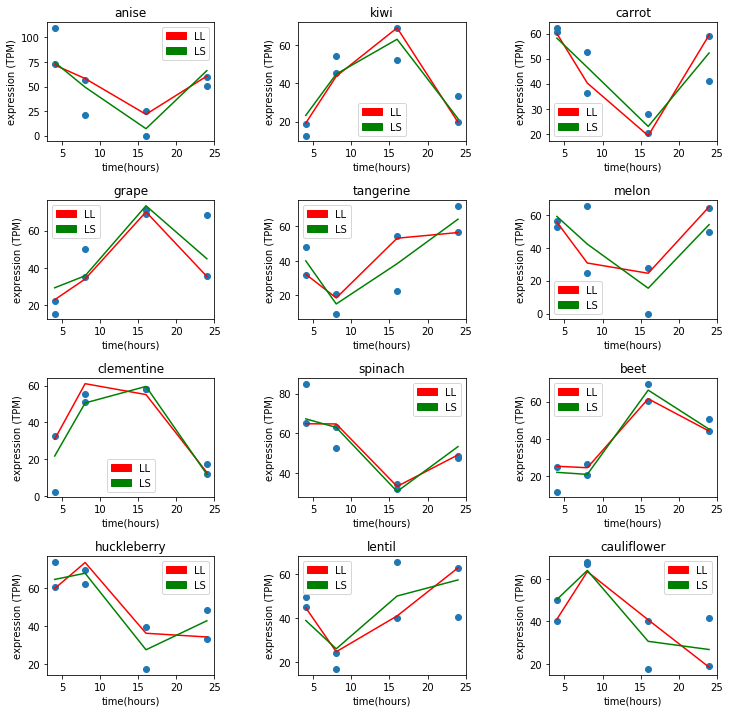

In [141]:
# graph the original observations against times adding the predictions of both methods
# log likelihood method = LL, least square method (Moriarty's) = LS

r_patch = mpatches.Patch(color='red', label='LL')
g_patch = mpatches.Patch(color='green', label='LS')

x =np.array([4., 4., 8., 8., 16., 16., 24., 24.], None) # times of each experiment

y0 = genes # observations

y1 = my_pred # LL method predictions 

y2 = mor_pred # LS method predictions

f, axarr = plt.subplots(4, 3, figsize=(12,12))
plt.subplots_adjust(hspace = .5, wspace=.5)

axarr[0, 0].plot(x,y0[0],'o')
axarr[0, 0].plot(x,y1[0],'-', color='r')
axarr[0, 0].plot(x,y2[0],'-', color='g')
axarr[0, 0].set_title(gene_name[0])

axarr[0, 1].plot(x,y0[1],'o')
axarr[0, 1].plot(x,y1[1],'-', color='r')
axarr[0, 1].plot(x,y2[1],'-', color='g')
axarr[0, 1].set_title(gene_name[1])

axarr[0, 2].plot(x,y0[2],'o')
axarr[0, 2].plot(x,y1[2],'-', color='r')
axarr[0, 2].plot(x,y2[2],'-', color='g')
axarr[0, 2].set_title(gene_name[2])

axarr[1, 0].plot(x,y0[3],'o')
axarr[1, 0].plot(x,y1[3],'-', color='r')
axarr[1, 0].plot(x,y2[3],'-', color='g')
axarr[1, 0].set_title(gene_name[3])

axarr[1, 1].plot(x,y0[4],'o')
axarr[1, 1].plot(x,y1[4],'-', color='r')
axarr[1, 1].plot(x,y2[4],'-', color='g')
axarr[1, 1].set_title(gene_name[4])

axarr[1, 2].plot(x,y0[5],'o')
axarr[1, 2].plot(x,y1[5],'-', color='r')
axarr[1, 2].plot(x,y2[5],'-', color='g')
axarr[1, 2].set_title(gene_name[5])

axarr[2, 0].plot(x,y0[6],'o')
axarr[2, 0].plot(x,y1[6],'-', color='r')
axarr[2, 0].plot(x,y2[6],'-', color='g')
axarr[2, 0].set_title(gene_name[6])

axarr[2, 1].plot(x,y0[7],'o')
axarr[2, 1].plot(x,y1[7],'-', color='r')
axarr[2, 1].plot(x,y2[7],'-', color='g')
axarr[2, 1].set_title(gene_name[7])

axarr[2, 2].plot(x,y0[8],'o')
axarr[2, 2].plot(x,y1[8],'-', color='r')
axarr[2, 2].plot(x,y2[8],'-', color='g')
axarr[2, 2].set_title(gene_name[8])

axarr[3, 0].plot(x,y0[9],'o')
axarr[3, 0].plot(x,y1[9],'-', color='r')
axarr[3, 0].plot(x,y2[9],'-', color='g')
axarr[3, 0].set_title(gene_name[9])

axarr[3, 1].plot(x,y0[10],'o')
axarr[3, 1].plot(x,y1[10],'-', color='r')
axarr[3, 1].plot(x,y2[10],'-', color='g')
axarr[3, 1].set_title(gene_name[10])

axarr[3, 2].plot(x,y0[11],'o')
axarr[3, 2].plot(x,y1[11],'-', color='r')
axarr[3, 2].plot(x,y2[11],'-', color='g')
axarr[3, 2].set_title(gene_name[11])
    
for ax in axarr.flat:
    ax.set(xlabel='time(hours)', ylabel='expression (TPM)')
    ax.legend(handles=[r_patch, g_patch])


##### As we can see from the plots, the log likelihood method is a better fit compared to the least squares method. This becomes more obvious when there is a large deviation between results of the same experiments. For example, if we look at melon, the 8hr experiment resulted in two very different observations depending on the sigma values (+-5 and +-20). The log likelihood method result fits the observation of the most accurate experiment (the one with +-5 sigma), while Moriarty's result is between the two observations.<br>Basically, the maximum likelihood method works better in this case because it determines which parameters are most like to produce the observed data taking into consideration which observations are more accurate in terms of standard error. On the other hand, the least squares method is averaging the differences by minmizing the sum of stanfard error, so it appears that the predictions from this method are average calculations between the accurate and inaccurate experiments.